In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

## Check controls: in-vitro array, and naked plasmid

#### This plasmid contains a part of the sequence of the ARS305 locus

In [2]:
ls controls/

DIES6_ALL_REP1_in_vitro_nucl_array.txt
DIES6_ALL_REP1_naked_plasmid.txt
DIES6_REP2_780READS_in_vitro_nucl_array.txt
DIES6_rep2_780READS_naked_plasmid.txt
INITIAL_in_vitro_nucl_array.fa
Tobias_nucarray_sequence_plus_annotations.fas
Tobias_nucarray_sequence_plus_annotations.sbd
array_both_strands/
array_disw2_rep1_780READS_noNA.csv
array_disw2_rep2_780READS_noNA_cleaned.csv
array_reverse/
array_smoothed_average_methylation_winsize_30.csv
array_smoothed_fold_changes_winsize_30.csv
in vitro arrayFINAL.fa
mat_Megalodon_repII_in_vitro_nucl_array.txt
naked_plasmid _updated_FINAL.fa
naked_plasmid.dna
naked_plasmid_disw2_rep1_clean_780READS.csv
naked_plasmid_disw2_rep2_clean_780_reads.csv
naked_plasmid_wt_rep2_1000reads.txt
plasmid_reverse/
plasmid_smoothed_average_methylation_winsize_30.csv
plasmid_smoothed_fold_changes_winsize_30.csv
plots/
test_wt_repIII_in_vitro_nucl_array_BOTHstrands.txt
unused_files/
wt_mat_Megalodon_repIII_in_vitro_nucl_array.txt
wt_mat_Megalodon_repIII_naked_plasmid.txt

In [3]:
wt_rep3_nucarray = np.loadtxt("controls/wt_mat_Megalodon_repIII_in_vitro_nucl_array.txt")
wt_rep3_nucarray.shape

(780, 1966)

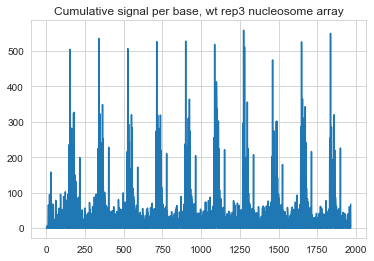

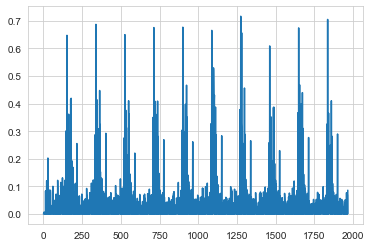

In [4]:
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]), y = np.cumsum(wt_rep3_nucarray, axis = 0)[779,:])
plt.title("Cumulative signal per base, wt rep3 nucleosome array")
plt.show()
#the last line of the array contains the cumulative occupation per base

sns.lineplot(x = range(wt_rep3_nucarray.shape[1]), y = np.mean(wt_rep3_nucarray, axis = 0))
plt.show()

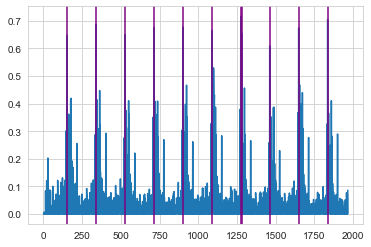

In [5]:
peaks = np.where(np.mean(wt_rep3_nucarray, axis = 0) >0.6)

sns.lineplot(x = range(wt_rep3_nucarray.shape[1]), y = np.mean(wt_rep3_nucarray, axis = 0))
for position in peaks[0]:
    plt.axvline(position, color = "purple")
plt.show()

In [6]:
np.gradient(peaks[0]).mean()

170.0

Text(0.5, 1.0, 'wt rep nuc array')

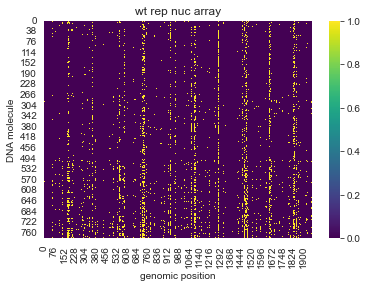

In [7]:
#heatmap of the wt raw data
sns.heatmap(wt_rep3_nucarray, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt rep nuc array")

### Test differrent window sizes for smoothing

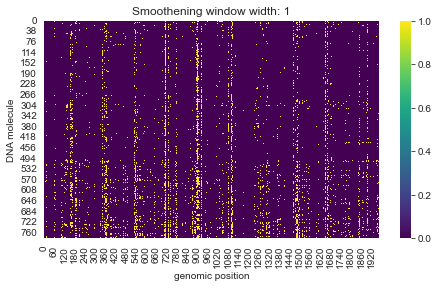

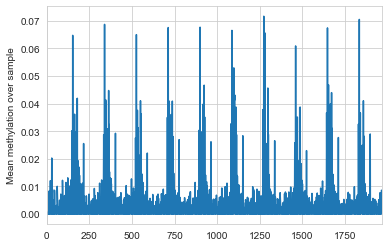

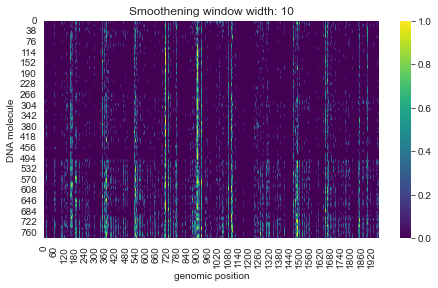

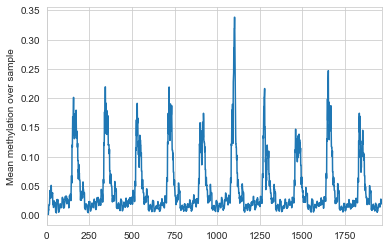

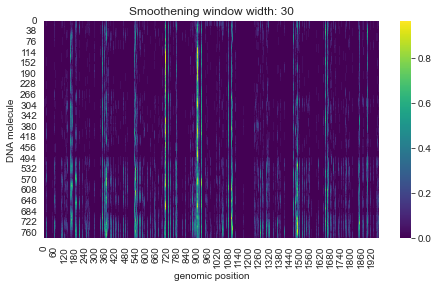

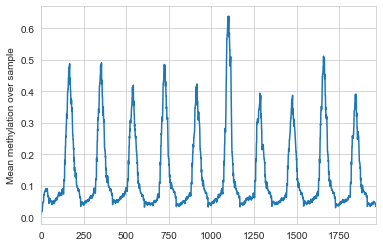

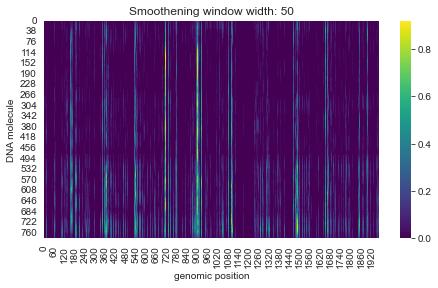

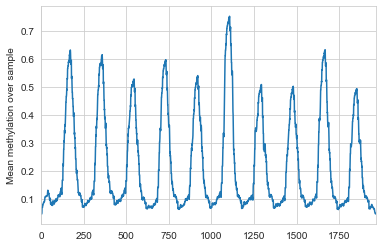

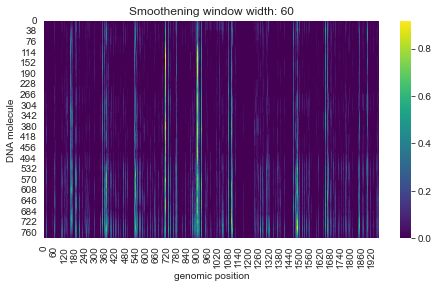

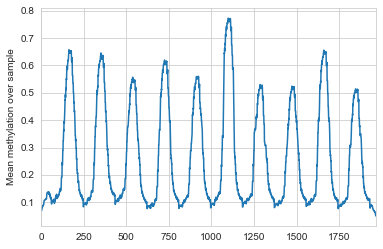

In [8]:
#calculate a sliding mean for each molecule
np.convolve(wt_rep3_nucarray[0,:], np.ones(10)/10, mode='same').shape

#N = 20 #smoothening window

#def smooth(array):
 #   return np.convolve(array, np.ones(N)/N, mode = "same")

for N in [1, 10, 30, 50, 60]:
    
    def smooth(array):
        return np.convolve(array, np.ones(N)/N, mode = "same")
    
    wt_nucarray_smooth = np.apply_along_axis(smooth, 0, wt_rep3_nucarray)
    
    plt.figure(figsize=(7.5,4))
    sns.heatmap(wt_nucarray_smooth, cmap = "viridis")
    plt.xlabel("genomic position")
    plt.ylabel("DNA molecule")
    plt.xlim(0, 1966)
    plt.title("Smoothening window width: " + str(N))
    plt.show()

    sns.lineplot(x = range(wt_nucarray_smooth.shape[1]), 
                 y = np.convolve(wt_nucarray_smooth.mean(axis = 0), np.ones(N)/10, mode ="same")
                )
    plt.ylabel("Mean methylation over sample")
    plt.xlim(0, 1966)
    plt.show()

In [9]:
# load the other replicate, and the counts from the mutants:

wt_rep2_nucarray = np.loadtxt("controls/mat_Megalodon_repII_in_vitro_nucl_array.txt")

dies6_rep1_nucarray = np.loadtxt("controls/DIES6_ALL_REP1_in_vitro_nucl_array.txt")
dies6_rep2_nucarray = np.loadtxt("controls/DIES6_REP2_780READS_in_vitro_nucl_array.txt")

disw2_rep1_nucarray = np.genfromtxt("controls/array_disw2_rep1_780READS_noNA.csv",
                                   dtype = int, delimiter = ",")

#disw2_rep2_nucarray = np.genfromtxt("controls/array_disw2_rep2_780READS_noNA.csv",
#                                   dtype = int, delimiter = ",")
#delete the first three columns as they come from linker DNA 
#disw2_rep2_nucarray_trimmed = disw2_rep2_nucarray[:, 30:]
#np.savetxt("controls/array_disw2_rep2_780READS_noNA_cleaned.csv", disw2_rep2_nucarray_trimmed)#

disw2_rep2_nucarray = np.loadtxt("controls/array_disw2_rep2_780READS_noNA_cleaned.csv")

In [10]:
#load the data for the reverse strand:

wt_rep3_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_repIII_in_vitro_nucl_array.txt") #780 reads
wt_rep2_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_repII_in_vitro_nucl_array.txt") #780 reads

dies6_rep1_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_in_vitro_nucl_array.txt") #780 reads
dies6_rep2_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_in_vitro_nucl_array.txt") #780 reds

disw2_rep1_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_in_vitro_nucl_array.txt") 
disw2_rep2_nucarray_rev = np.loadtxt("controls/array_reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_in_vitro_nucl_array.txt") #780 reads


In [11]:
print(wt_rep3_nucarray.shape, wt_rep3_nucarray_rev.shape)
print(wt_rep2_nucarray.shape, wt_rep2_nucarray_rev.shape)
print(dies6_rep1_nucarray.shape, dies6_rep1_nucarray_rev.shape)
print(dies6_rep2_nucarray.shape, dies6_rep2_nucarray_rev.shape)
print(disw2_rep1_nucarray.shape, disw2_rep1_nucarray_rev.shape)
print(disw2_rep2_nucarray.shape, disw2_rep2_nucarray_rev.shape)

#subsample wt_rep2 plus strand to 780 bases
#to join fw +rev, 

(780, 1966) (780, 1970)
(1000, 1966) (780, 1970)
(780, 1966) (780, 1970)
(780, 1966) (780, 1970)
(780, 1966) (780, 1970)
(780, 1966) (780, 1970)


In [12]:
#since the separate strands have different length, load the count matrices for all the conditions

wt_rep3_dbs = np.loadtxt("controls/array_both_strands/mat_Megalodon_repIII_in_vitro_nucl_arrayBOTHstrands.txt")
print(wt_rep3_dbs.shape)
wt_rep2_dbs = np.loadtxt("controls/array_both_strands/mat_Megalodon_repII_in_vitro_nucl_array.txt")

dies6_rep1_dbs = np.loadtxt("controls/array_both_strands/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_in_vitro_nucl_array.txt")
dies6_rep2_dbs = np.loadtxt("controls/array_both_strands/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_in_vitro_nucl_array.txt")

disw2_rep1_dbs = np.loadtxt("controls/array_both_strands/mat_Megalodon_20211201_all_strains_disw2_REP1_in_vitro_nucl_array.txt")
disw2_rep2_dbs = np.loadtxt("controls/array_both_strands/mat_Megalodon_20220221_disw2_all_meth_REP2_in_vitro_nucl_array.txt")

(1000, 1970)


In [13]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_dbs, 
             "wt_rep2": wt_rep2_dbs, 
             "dies6_rep1": dies6_rep1_dbs,
            "dies6_rep2": dies6_rep2_dbs,
            "disw2_rep1": disw2_rep1_dbs,
            "disw2_rep2": disw2_rep2_dbs}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
print("Summary nucleosomal array, both strands")
summary

Summary nucleosomal array, both strands


,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1970.0,0.048283,0.063324,0.0,0.014000,0.025000,0.049000,0.406000,1000
wt_rep2,1970.0,0.034160,0.044906,0.0,0.010256,0.017949,0.035897,0.282051,1560
dies6_rep1,1970.0,0.050732,0.056342,0.0,0.016026,0.028205,0.064103,0.342949,1560
dies6_rep2,1970.0,0.045048,0.057837,0.0,0.012821,0.021154,0.048077,0.346795,1560
disw2_rep1,1970.0,0.061350,0.064444,0.0,0.017949,0.036538,0.079487,0.341667,1560
disw2_rep2,1970.0,0.059359,0.062727,0.0,0.017949,0.033333,0.077404,0.338462,1560


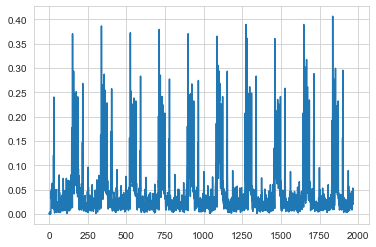

<AxesSubplot:>

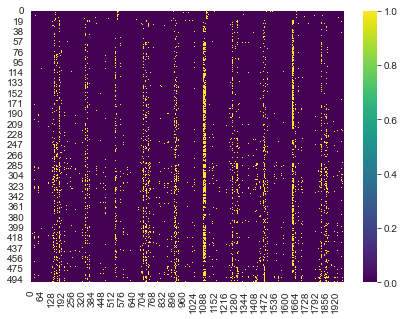

In [14]:
sns.lineplot(x=range(1970), y= wt_rep3_dbs.mean(axis=0))
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(wt_rep3_dbs[500:,:], cmap="viridis")

In [15]:
### that doesn't work yet until we know how to align the + and - strand
"""
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

#subsample dies6_rep2_rev to 715 reads
wt_rep2_rev_sub = subsample(wt_rep2_rev, 715)
wt_rep2_join = np.concatenate((ARS305_wt_rep2[:, 1:], wt_rep2_rev_sub), axis = 0)

dies6_rep1_join = np.concatenate((ARS305_dies6_rep1[:, 1:], dies6_rep1_rev), axis = 0)
dies6_rep2_join = np.concatenate((ARS305_dies6_rep2[:, 1:], dies6_rep2_rev), axis = 0)

disw2_rep1_join = np.concatenate((ARS305_disw2_rep1[:, 1:], disw2_rep1_rev), axis = 0)
disw2_rep2_join = np.concatenate((ARS305_disw2_rep2[:, 1:], disw2_rep2_rev), axis = 0)"""

'\ndef subsample(array, n):\n    np.random.seed(15)\n    idx = np.random.randint(len(array), size=n)\n    return array[idx,:]\n\n#subsample dies6_rep2_rev to 715 reads\nwt_rep2_rev_sub = subsample(wt_rep2_rev, 715)\nwt_rep2_join = np.concatenate((ARS305_wt_rep2[:, 1:], wt_rep2_rev_sub), axis = 0)\n\ndies6_rep1_join = np.concatenate((ARS305_dies6_rep1[:, 1:], dies6_rep1_rev), axis = 0)\ndies6_rep2_join = np.concatenate((ARS305_dies6_rep2[:, 1:], dies6_rep2_rev), axis = 0)\n\ndisw2_rep1_join = np.concatenate((ARS305_disw2_rep1[:, 1:], disw2_rep1_rev), axis = 0)\ndisw2_rep2_join = np.concatenate((ARS305_disw2_rep2[:, 1:], disw2_rep2_rev), axis = 0)'

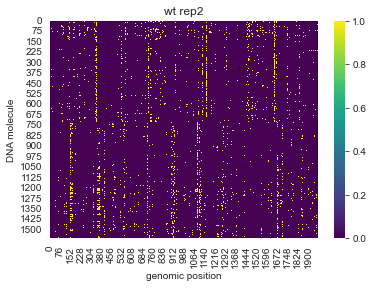

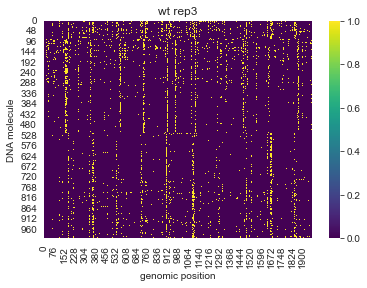

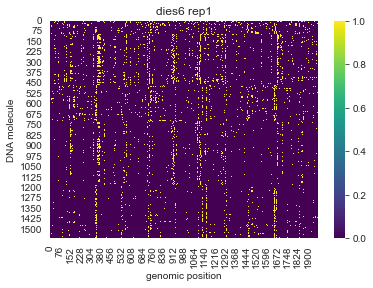

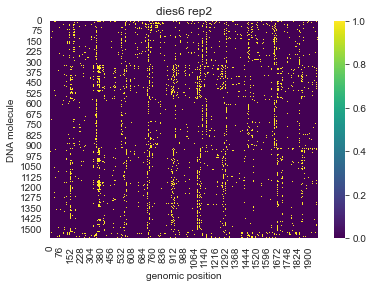

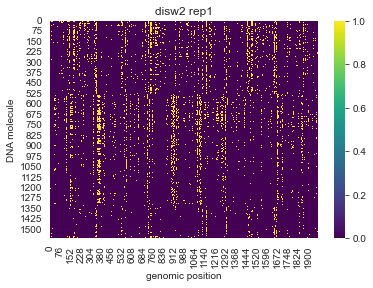

Text(0.5, 1.0, 'disw2 rep2')

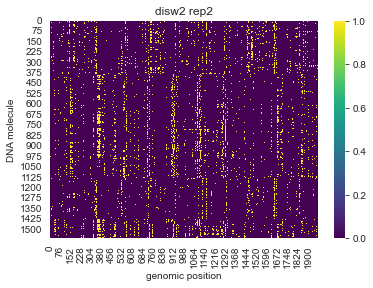

In [16]:
sns.heatmap(wt_rep2_dbs, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt rep2")
plt.show()

sns.heatmap(wt_rep3_dbs, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt rep3")
plt.show()

sns.heatmap(dies6_rep1_dbs, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("dies6 rep1")
plt.show()

sns.heatmap(dies6_rep2_dbs, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("dies6 rep2")
plt.show()

sns.heatmap(disw2_rep1_dbs, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("disw2 rep1")
plt.show()

sns.heatmap(disw2_rep2_dbs, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("disw2 rep2")

### compare replicates smoothed mean and variance of wildtype and mutants dies6 and disw2

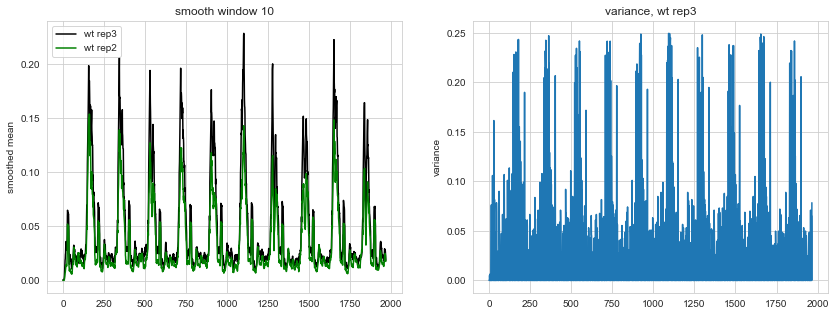

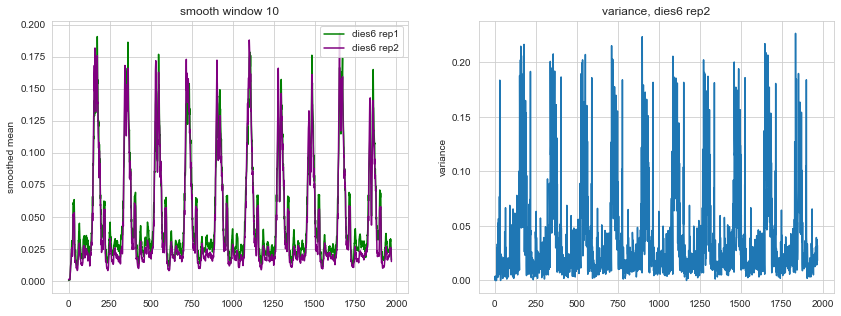

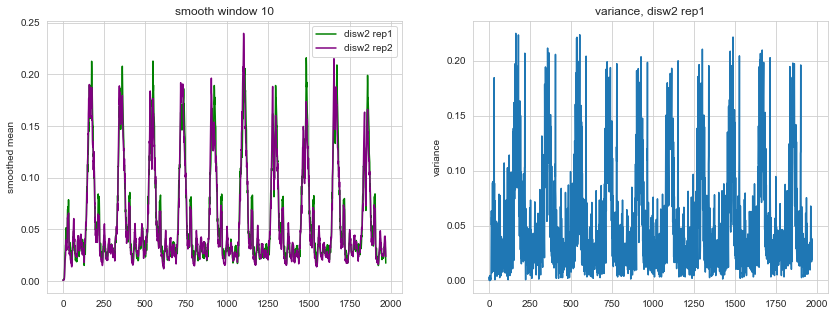

wt:  3.6679572617529154e-102
dies6:  5.234857328878377e-57
disw2:  0.02275886341794949


In [17]:
smooth = 10

#wildtype
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.lineplot(x = range(wt_rep3_dbs.shape[1]), 
                 y = np.convolve(wt_rep3_dbs.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "black", label = "wt rep3", ax = ax1)
sns.lineplot(x = range(wt_rep2_dbs.shape[1]), 
                 y = np.convolve(wt_rep2_dbs.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "green", label = "wt rep2", ax = ax1)
ax1.set_ylabel("smoothed mean")
ax1.set_title("smooth window " + str(smooth))

sns.lineplot(x = range(wt_rep3_nucarray.shape[1]), 
                 y = wt_rep3_nucarray.std(axis = 0)**2, ax = ax2)
plt.ylabel("variance")
ax2.set_title("variance, wt rep3")
plt.show()

#DIES6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.lineplot(x = range(wt_rep3_dbs.shape[1]), 
                 y = np.convolve(dies6_rep1_dbs.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "green", label = "dies6 rep1", ax = ax1)
sns.lineplot(x = range(wt_rep3_dbs.shape[1]), 
                 y = np.convolve(dies6_rep2_dbs.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "purple", label = "dies6 rep2", ax = ax1)
ax1.set_ylabel("smoothed mean")
ax1.set_title("smooth window " + str(smooth))

sns.lineplot(x = range(wt_rep3_dbs.shape[1]), 
                 y = dies6_rep2_dbs.std(axis = 0)**2, ax = ax2)
plt.ylabel("variance")
ax2.set_title("variance, dies6 rep2")
plt.show()

#DISW2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.lineplot(x = range(wt_rep3_dbs.shape[1]), 
                 y = np.convolve(disw2_rep1_dbs.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "green", label = "disw2 rep1", ax = ax1)
sns.lineplot(x = range(wt_rep3_dbs.shape[1]), 
                 y = np.convolve(disw2_rep2_dbs.mean(axis = 0), np.ones(smooth)/smooth, mode ="same"),
             color = "purple", label = "disw2 rep2", ax = ax1)
ax1.set_ylabel("smoothed mean")
ax1.set_title("smooth window " + str(smooth))

sns.lineplot(x = range(wt_rep3_dbs.shape[1]), 
                 y = disw2_rep1_dbs.std(axis = 0)**2, ax = ax2)
plt.ylabel("variance")
ax2.set_title("variance, disw2 rep1")
plt.show()

print("wt: ", wilcoxon(wt_rep3_nucarray.mean(axis = 0), wt_rep2_nucarray.mean(axis =0), 
               alternative ="two-sided").pvalue)
print("dies6: ", wilcoxon(dies6_rep1_nucarray.mean(axis = 0), dies6_rep2_nucarray.mean(axis =0), 
               alternative ="two-sided").pvalue)
print("disw2: ", wilcoxon(disw2_rep1_nucarray.mean(axis = 0), disw2_rep2_nucarray.mean(axis =0), 
               alternative ="two-sided").pvalue)

In [18]:
wt_rep3_smooth_mean = np.convolve(wt_rep3_nucarray.mean(axis = 0), np.ones(smooth)/smooth, mode ="same")
wt_rep2_smooth_mean = np.convolve(wt_rep2_nucarray.mean(axis = 0), np.ones(smooth)/smooth, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1_nucarray.mean(axis = 0), np.ones(smooth)/smooth, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2_nucarray.mean(axis = 0), np.ones(smooth)/smooth, mode ="same")

means_nucarray = np.concatenate((wt_rep3_smooth_mean.reshape(1, 1966),
                                 wt_rep2_smooth_mean.reshape(1, 1966),
                              dies6_rep1_smooth_mean.reshape(1, 1966),
                              dies6_rep2_smooth_mean.reshape(1, 1966)),
                              axis = 0)

w, p = wilcoxon(means_nucarray[2,:], means_nucarray[3,:], alternative = "two-sided")
print("Comparing dies6 replicates after smoothing: ", w,p)

#the statistical test shows that the replicates of the mutants are rather different: 
w_2, p_2 = wilcoxon(dies6_rep1_nucarray.mean(axis = 0), 
                    dies6_rep2_nucarray.mean(axis = 0), alternative = "two-sided") #p-value 5.23 * e-57
print("comparing dies6 replicates: ", w_2, p_2)

#disw2 replicates pass the statistical test for being similar:
w_3, p_3 = wilcoxon(disw2_rep1_nucarray.mean(axis = 0), 
                    disw2_rep2_nucarray.mean(axis = 0), alternative = "two-sided")
print(w_3, p_3)

#disw2 replicates pass the statistical test for being similar:
w_4, p_4 = wilcoxon(wt_rep3_nucarray.mean(axis = 0), 
                    wt_rep2_nucarray.mean(axis = 0), alternative = "two-sided")
print("Comparing wild-type replictes: ", w_4, p_4)

Comparing dies6 replicates after smoothing:  241070.5 4.20341137964683e-182
comparing dies6 replicates:  83049.0 5.234857328878377e-57
193039.5 0.02275886341794949
Comparing wild-type replictes:  44512.0 3.6679572617529154e-102


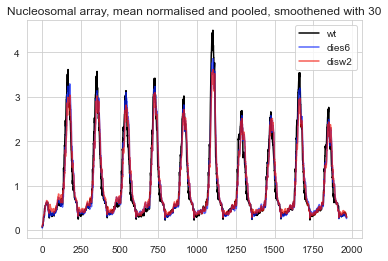

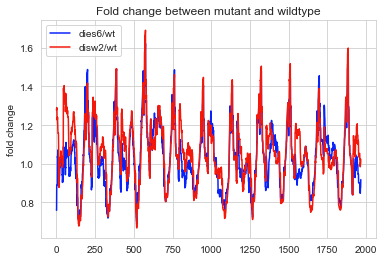

In [19]:
#minmax normalize the replicates, plot the smoothed mean and export data for external plotting for manuscript

wt_rep3_minmax = wt_rep3_nucarray.mean(axis = 0)/wt_rep3_nucarray.flatten().mean(axis = 0)
wt_rep2_minmax = wt_rep2_nucarray.mean(axis = 0)/wt_rep2_nucarray.flatten().mean(axis = 0)

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1_nucarray.mean(axis = 0)/dies6_rep1_nucarray.flatten().mean(axis = 0)
dies6_rep2_minmax = dies6_rep2_nucarray.mean(axis = 0)/dies6_rep2_nucarray.flatten().mean(axis = 0)

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), 
                              axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1_nucarray.mean(axis = 0)/disw2_rep1_nucarray.flatten().mean(axis = 0)
disw2_rep2_minmax = disw2_rep2_nucarray.mean(axis = 0)/disw2_rep2_nucarray.flatten().mean(axis = 0)

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)


N=30
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), 
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"),
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Nucleosomal array, mean normalised and pooled, smoothened with " + str(N)) 
#plt.savefig("controls/nucarray_scaled_pooled_data.png", dpi = 300)
plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#0a22fa", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#f2180c",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

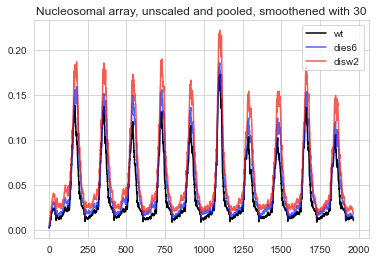

In [20]:
#Compare to non-scaled data:

unscaled_disw2_pooled = np.concatenate((disw2_rep1_nucarray, disw2_rep2_nucarray), axis = 0).mean(axis = 0)
unscaled_dies6_pooled = np.concatenate((dies6_rep1_nucarray, dies6_rep2_nucarray), axis = 0).mean(axis = 0)
unscaled_wt_pooled = np.concatenate((wt_rep3_nucarray, wt_rep2_nucarray), axis = 0).mean(axis = 0)

N=30
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]),
             y = np.convolve(unscaled_wt_pooled, np.ones(N)/N, mode="same"), 
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]),
             y = np.convolve(unscaled_dies6_pooled, np.ones(N)/N, mode="same"),
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]),
            y = np.convolve(unscaled_disw2_pooled, np.ones(N)/N, mode = "same"), 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Nucleosomal array, unscaled and pooled, smoothened with " + str(N)) 
plt.show()
#plt.savefig("controls/nucarray_pooled_data.png", dpi = 300)

<AxesSubplot:>

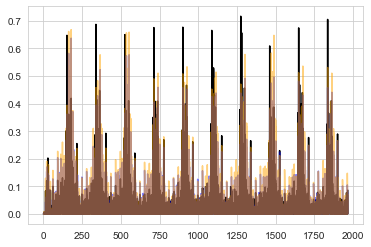

In [21]:
#sns.lineplot(x = range(wt_rep3_nucarray.shape[1]),
#             y = pooled_wt, 
#             color = "black")
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]),
             y = wt_rep3_nucarray.mean(axis=0), 
             color = "black")
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]),
             y = dies6_rep1_nucarray.mean(axis=0), 
             color = "blue", alpha = 0.5)
sns.lineplot(x = range(wt_rep3_nucarray.shape[1]),
             y = disw2_rep1_nucarray.mean(axis=0), 
             color = "orange", alpha = 0.5)

## Test whether the efficiency is sequence dependent

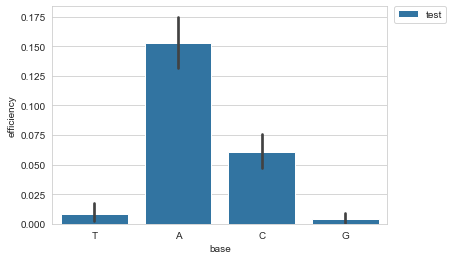

In [22]:
#seq="TATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGC"
seq="TATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTGTTAACGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCTAGGTGAATCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGATGCATACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGCCTTAAGTCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGTTATAACTATCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGAGATCTATCCCC"

#seq=seq.lower()

eff_df = pd.DataFrame({"test": dies6_rep1_nucarray.mean(axis=0)[11:544]}, index=range(533))
eff_df["base"] = [letter for letter in seq]
eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

sns.barplot(data = eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

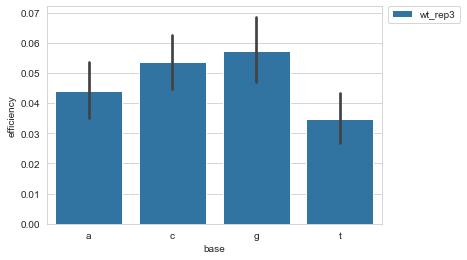

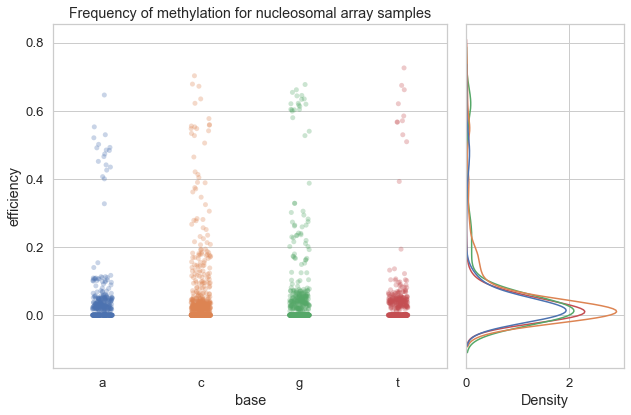

In [23]:
#seq="TATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTGTTAACGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCTAGGTGAATCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGATGCATACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGCCTTAAGTCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGTTATAACTATCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGAGATCTATCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTATACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCCCATGGAATCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGGCCACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGTGATCAATCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGGCCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGCGTTGGGCCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTCTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGACATGTATCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGTACTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGCGTGGATCCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTACAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCCATATGAATCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTTTAAACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGGCCGCGTGGTACCCCCGAGAATCGGATCTTACATGCACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGC"
#wt_rep3_nucarray.mean(axis=0)[11:]}, index=range(1955)

#sequence bases 30-1999 from Tobias
#seq_fw="catgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagttaactacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcctaggccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagatgcatacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcttaagccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagcttataacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgagatctccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctgtatacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgccatggccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctggccacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgtgatcaccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctaggcctgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcggggcccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctctctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgacatgtccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagtactgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgggatccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctacagctgtctacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgcatatgccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcggtgctagagctttaaacgaccaattgagcggcctcggcaccgggattctccagggcggccgcgggtaccccccgagaatcggatcttacatgcacaggatgtatatatctgacacgtgcctggagactagggagtaatccccttggcggttaaaacgcgggggacagcgcgtacgtgcgtttaagcgg"
#revrese complement to check the reverse strand:
#seq="ccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggggtacccgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtttaaagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggcatatgcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagacagctgtagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggggatcccgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagacagtactagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggacatgtcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagagagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcgggggggccccgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagacaggcctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggtgatcacgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtggccagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggccatggcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtatacagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggagatctcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgttataagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggcttaagcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtatgcatctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggcctaggcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagttaactctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatg"
#seq=seq.lower()

seq="accgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggggtacccgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtttaaagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggcatatgcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagacagctgtagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggggatcccgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagacagtactagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggacatgtcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagagagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcgggggggccccgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagacaggcctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggtgatcacgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtggccagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggccatggcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtatacagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggagatctcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgttataagctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggcttaagcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtatgcatctctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcatgtaagatccgattctcggggcctaggcgcggccgccctggagaatcccggtgccgaggccgctcaattggtcgtagttaactctagcaccgcttaaacgcacgtacgcgctgtcccccgcgttttaaccgccaaggggattactccctagtctccaggcacgtgtcagatatatacatcctgtgcat"
#seq = seq.lower()
#eff_df = pd.DataFrame({"wt_rep3": wt_rep3_nucarray.mean(axis=0)[11:]}, index=range(1955))
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_nucarray_rev.mean(axis=0)}, index=range(1970))


eff_df["base"] = [letter for letter in seq]
#eff_df["wt_rep2"]    = wt_rep2_nucarray.mean(axis=0)[11:]
#eff_df["dies6_rep1"] = dies6_rep1_nucarray.mean(axis=0)[11:]
#eff_df["dies6_rep2"] = dies6_rep2_nucarray.mean(axis=0)[11:]
#eff_df["disw2_rep1"] = disw2_rep1_nucarray.mean(axis=0)[11:]
#eff_df["disw2_rep2"] = disw2_rep2_nucarray.mean(axis=0)[11:]

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

sns.barplot(data = eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.3, ax= axs[0])
axs[0].set_title("Frequency of methylation for nucleosomal array samples")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()

## Export data for the nucleosomal array

In [25]:
#Exporting aggregated data for Anna to plot for the manuscript 
#6th July 2022

smooth_width=30
smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


array_smooth_30 = pd.DataFrame.from_dict(smooth)
array_smooth_30.index = array_smooth_30.index + 1
#array_smooth_30.to_csv("controls/array_smoothed_average_methylation_winsize_30.csv")

## Check the negative control: "naked plasmid"

#### purified plasmid was added after locus purification. should have ~uniform methylation

In [26]:
wt_rep3_naked_plasmid = np.loadtxt("controls/wt_mat_Megalodon_repIII_naked_plasmid.txt")
#wt_rep2_naked_plasmid = np.loadtxt("controls/mat_Megalodon_repII_naked_plasmid.txt")

In [27]:
set(wt_rep3_naked_plasmid.flatten())
np.isnan(wt_rep3_naked_plasmid).sum()

wt_rep3_naked_plasmid.mean(axis = 0)

array([0.        , 0.        , 0.67820513, ..., 0.00769231, 0.00384615,
       0.02435897])

In [28]:
def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

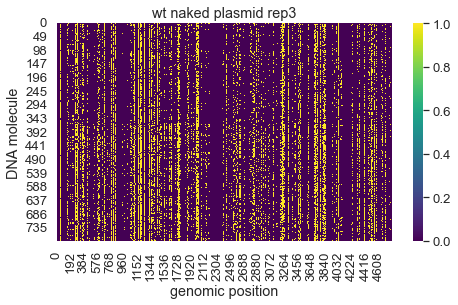

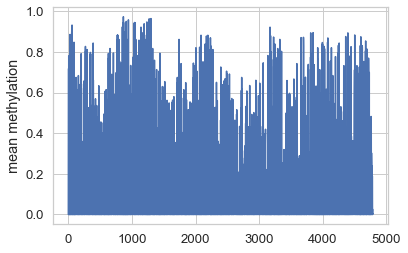

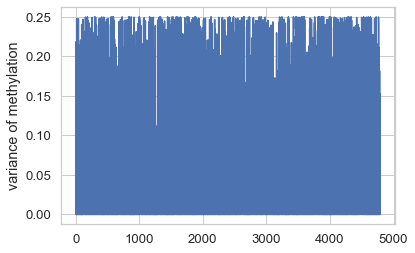

<AxesSubplot:title={'center':'naked plasmid wt rep3, entropy per position'}, ylabel='entropy'>

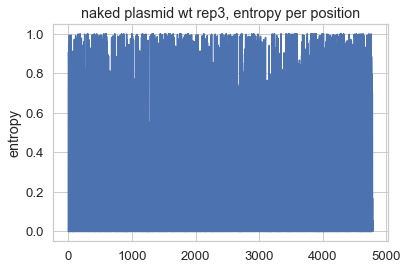

In [29]:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_naked_plasmid, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.title("wt naked plasmid rep3")
plt.show()

sns.lineplot(x = range(wt_rep3_naked_plasmid.shape[1]), 
             y = wt_rep3_naked_plasmid.mean(axis = 0))
plt.ylabel("mean methylation")
plt.show()

sns.lineplot(x = range(wt_rep3_naked_plasmid.shape[1]), 
             y = wt_rep3_naked_plasmid.std(axis = 0)**2)
plt.ylabel("variance of methylation")
plt.show()

g = sns.lineplot(x = range(wt_rep3_naked_plasmid.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3_naked_plasmid))
g.set_ylabel("entropy")
g.set_title("naked plasmid wt rep3, entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

<AxesSubplot:title={'center':'nucarray wt rep3, entropy per position'}, ylabel='entropy'>

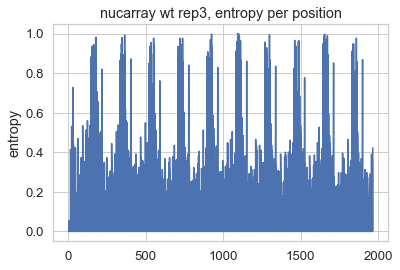

In [30]:
g = sns.lineplot(x = range(wt_rep3_nucarray.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3_nucarray))
g.set_ylabel("entropy")
g.set_title("nucarray wt rep3, entropy per position")
g

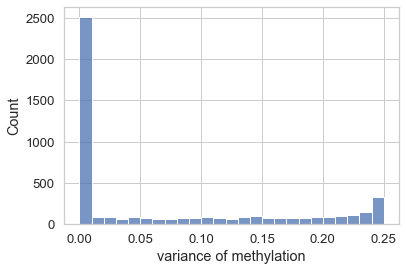

In [31]:
sns.histplot(x = wt_rep3_naked_plasmid.std(axis = 0)**2, binwidth= 0.01)
plt.xlabel("variance of methylation")
plt.show()

<AxesSubplot:ylabel='Count'>

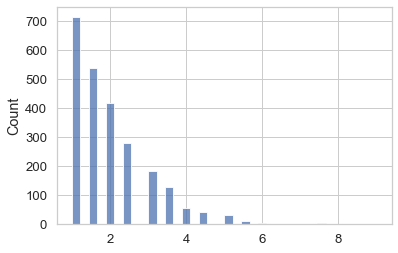

In [32]:
#How evenly are the ones ditributed over the whole sequence?
sns.histplot(np.gradient(np.where(wt_rep3_naked_plasmid.std(axis = 0)**2 == 0)[0]))

In [33]:
### Cleaning two of the files for "naked plasmid" : removing NAs and non binary counts:

#wt_rep2_naked_plasmid = pd.read_csv("controls/mat_Megalodon_repII_naked_plasmid.txt", sep= "\t", header=None)
#wt_rep2_naked_plasmid.drop(columns = [4791, 4792, 4793], inplace = True)
#clean_df = wt_rep2_naked_plasmid.loc[:999,]

#clean_array = clean_df.values
#np.savetxt("controls/naked_plasmid_wt_rep2_1000reads.txt", clean_array)

#clean_disw2 = pd.read_csv("controls/unused_csvs/naked_plasmid_disw2_rep2_780READS_noNA.csv", header = None)
#clean_disw2.drop(columns = range(4791, 4795), inplace = True)
#clean_array2 = clean_disw2.loc[:779,].values

#np.savetxt("controls/naked_plasmid_disw2_rep2_clean_780_reads.csv", clean_array2)

#disw2_rep1_naked = np.genfromtxt("controls/naked_plasmid_disw2_rep1_780READS.csv",
#                                        dtype = int, delimiter = ",")
#clean_array3 = disw2_rep1_naked[:780,:4791]
#np.savetxt("controls/naked_plasmid_disw2_rep1_clean_780READS.csv", clean_array3)

In [34]:
wt_rep3_naked_plasmid = np.loadtxt("controls/wt_mat_Megalodon_repIII_naked_plasmid.txt")
wt_rep2_naked_plasmid = np.loadtxt("controls/naked_plasmid_wt_rep2_1000reads.txt") #1000 reads
#np.random.seed(0)
#wt_rep2_naked_plasmid = subsample(wt_rep2_naked_plasmid, 780)
wt_rep2_naked_plasmid = wt_rep2_naked_plasmid[:780,:]

dies6_rep1_naked = np.loadtxt("controls/DIES6_ALL_REP1_naked_plasmid.txt")
dies6_rep2_naked = np.loadtxt("controls/DIES6_rep2_780READS_naked_plasmid.txt")

disw2_rep1_naked = np.loadtxt("controls/naked_plasmid_disw2_rep1_clean_780READS.csv")
disw2_rep2_naked = np.loadtxt("controls/naked_plasmid_disw2_rep2_clean_780_reads.csv")

#Load methylation data for the reverse strand:

wt_rep3_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_repIII_naked_plasmid.txt")
wt_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_repII_naked_plasmid.txt")

dies6_rep1_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_naked_plasmid.txt")
dies6_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_naked_plasmid.txt")

disw2_rep1_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_naked_plasmid.txt")
disw2_rep2_plasmid_rev = np.loadtxt("controls/plasmid_reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_naked_plasmid.txt")

Text(0.5, 1.0, 'naked plasmid wt rep2 rev, entropy per position')

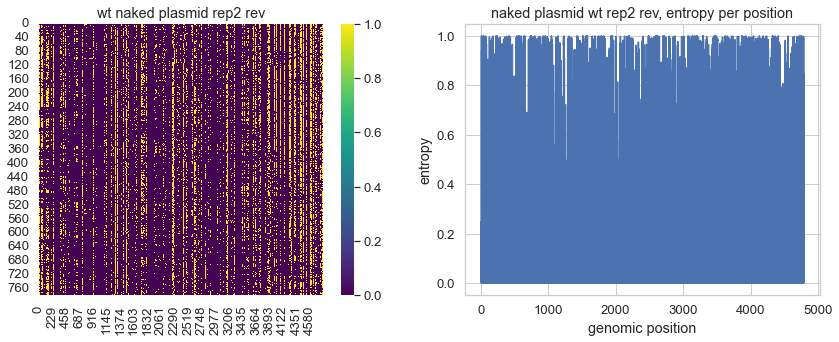

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

#sns.set(rc={'figure.figsize':(14, 5)})
sns.heatmap(wt_rep2_plasmid_rev, cmap = "viridis", ax =ax1)
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
ax1.set_title("wt naked plasmid rep2 rev")

sns.set_style("whitegrid")
sns.lineplot(x = range(wt_rep2_plasmid_rev.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep2_plasmid_rev), ax = ax2)
plt.ylabel("entropy")
ax2.set_title("naked plasmid wt rep2 rev, entropy per position")

<AxesSubplot:title={'center':'naked plasmid disw2 rep1, entropy per position'}, ylabel='entropy'>

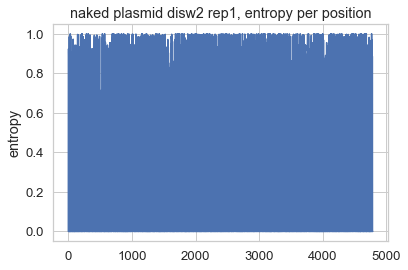

In [36]:
g = sns.lineplot(x = range(disw2_rep1_naked.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, disw2_rep1_naked))
g.set_ylabel("entropy")
g.set_title("naked plasmid disw2 rep1, entropy per position")
g

In [37]:
wt_rep3_plasmid_join = np.concatenate((wt_rep3_naked_plasmid, wt_rep3_plasmid_rev[:, :-1]), axis = 0)
wt_rep2_plasmid_join = np.concatenate((wt_rep2_naked_plasmid, wt_rep2_plasmid_rev[:, :-1]), axis = 0)

dies6_rep1_plasmid_join = np.concatenate((dies6_rep1_naked, dies6_rep1_plasmid_rev[:, :-1]), axis = 0)
dies6_rep2_plasmid_join = np.concatenate((dies6_rep2_naked, dies6_rep2_plasmid_rev[:, :-1]), axis = 0)

disw2_rep1_plasmid_join = np.concatenate((disw2_rep1_naked, disw2_rep1_plasmid_rev[:, :-1]), axis = 0)
disw2_rep2_plasmid_join = np.concatenate((disw2_rep2_naked, disw2_rep2_plasmid_rev[:, :-1]), axis = 0)

In [38]:
#overwrite varibale names fro the normlaisation to the plasmid methylation later 
wt_rep3_naked_plasmid = wt_rep3_plasmid_join
wt_rep2_naked_plasmid = wt_rep2_plasmid_join

dies6_rep1_naked = dies6_rep1_plasmid_join
dies6_rep2_naked = dies6_rep2_plasmid_join 

disw2_rep1_naked = disw2_rep1_plasmid_join 
disw2_rep2_naked = disw2_rep2_plasmid_join

## Plot the per base efficiency for the plasmid:

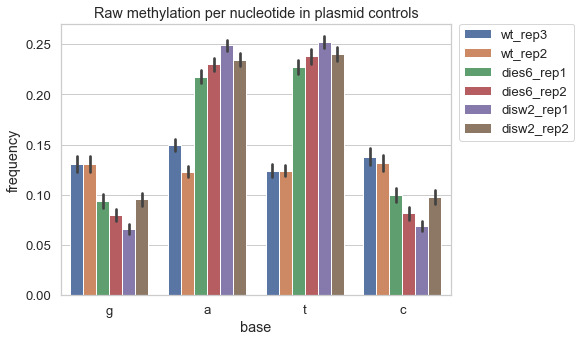

<AxesSubplot:title={'center':'Methylation frequency over samples'}, xlabel='sample', ylabel='frequency of methylation'>

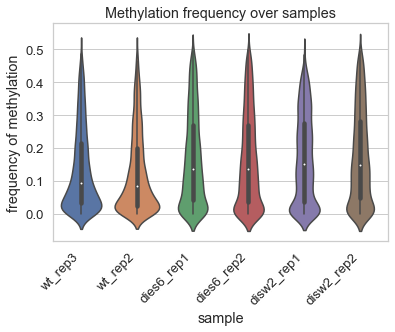

In [39]:
#prepare the data:
seq="ggaagatcctctagagtcgacccgagatcatatcactgtggacgttgatgaaagaatacgttattctttcatcaaatcgtggggctctagggtagttgcgtttctctcattgggacactgaacctcattttccaacattttggtcatgtaagaggcgacaggctcatcgcaggtgggtgcatcaacatggtagtacctggaccaagcgctacattgagtccctcctggataaacaccgctacaatattgtctttggacgtttgcccaaaccatatcttttgaataccaaagctggaccacattgtatggcctaatcattggtgctaccataatactggattgggaaacagtctggttaatttttttcaaccaatttttcttatctagcaatgatttaataaacctgaaatctaaattgtcttcgttagcgtctgtgtcataatctacaattgagtactgtgacgtccaattatatggcaccgagatggggaatctgtccggtgtttcgtcgctgttatccttctcctccctccaaatgaattcctgcagcccgggggatccactagttctagagcggccgccaccgcggtggagctccagcttttgttccctttagtgagggttaatttcgagcttggcgtaatcatggtcatagctgtttcctgtgtgaaattgttatccgctcacaattccacacaacatacgagccggaagcataaagtgtaaagcctggggtgcctaatgagtgagctaactcacattaattgcgttgcgctcactgcccgctttccagtcgggaaacctgtcgtgccagctgcattaatgaatcggccaacgcgcggggagaggcggtttgcgtattgggcgctcttccgcttcctcgctcactgactcgctgcgctcggtcgttcggctgcggcgagcggtatcagctcactcaaaggcggtaatacggttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctccgcccccctgacgagcatcacaaaaatcgacgctcaagtcagaggtggcgaaacccgacaggactataaagataccaggcgtttccccctggaagctccctcgtgcgctctcctgttccgaccctgccgcttaccggatacctgtccgcctttctcccttcgggaagcgtggcgctttctcatagctcacgctgtaggtatctcagttcggtgtaggtcgttcgctccaagctgggctgtgtgcacgaaccccccgttcagcccgaccgctgcgccttatccggtaactatcgtcttgagtccaacccggtaagacacgacttatcgccactggcagcagccactggtaacaggattagcagagcgaggtatgtaggcggtgctacagagttcttgaagtggtggcctaactacggctacactagaaggacagtatttggtatctgcgctctgctgaagccagttaccttcggaaaaagagttggtagctcttgatccggcaaacaaaccaccgctggtagcggtggtttttttgtttgcaagcagcagattacgcgcagaaaaaaaggatctcaagaagatcctttgatcttttctacggggtctgacgctcagtggaacgaaaactcacgttaagggattttggtcatgagattatcaaaaaggatcttcacctagatccttttaaattaaaaatgaagttttaaatcaatctaaagtatatatgagtaaacttggtctgacagttaccaatgcttaatcagtgaggcacctatctcagcgatctgtctatttcgttcatccatagttgcctgactccccgtcgtgtagataactacgatacgggagggcttaccatctggccccagtgctgcaatgataccgcgagacccacgctcaccggctccagatttatcagcaataaaccagccagccggaagggccgagcgcagaagtggtcctgcaactttatccgcctccatccagtctattaattgttgccgggaagctagagtaagtagttcgccagttaatagtttgcgcaacgttgttgccattgctacaggcatcgtggtgtcacgctcgtcgtttggtatggcttcattcagctccggttcccaacgatcaaggcgagttacatgatcccccatgttgtgcaaaaaagcggttagctccttcggtcctccgatcgttgtcagaagtaagttggccgcagtgttatcactcatggttatggcagcactgcataattctcttactgtcatgccatccgtaagatgcttttctgtgactggtgagtactcaaccaagtcattctgagaatagtgtatgcggcgaccgagttgctcttgcccggcgtcaatacgggataataccgcgccacatagcagaactttaaaagtgctcatcattggaaaacgttcttcggggcgaaaactctcaaggatcttaccgctgttgagatccagttcgatgtaacccactcgtgcacccaactgatcttcagcatcttttactttcaccagcgtttctgggtgagcaaaaacaggaaggcaaaatgccgcaaaaaagggaataagggcgacacggaaatgttgaatactcatactcttcctttttcaatattattgaagcatttatcagggttattgtctcatgagcggatacatatttgaatgtatttagaaaaataaacaaataggggttccgcgcacatttccccgaaaagtgccacctaaattgtaagcgttaatattttgttaaaattcgcgttaaatttttgttaaatcagctcattttttaaccaataggccgaaatcggcaaaatcccttataaatcaaaagaatagaccgagatagggttgagtgttgttccagtttggaacaagagtccactattaaagaacgtggactccaacgtcaaagggcgaaaaaccgtctatcagggcgatggcccactacgtgaaccatcaccctaatcaagttttttggggtcgaggtgccgtaaagcactaaatcggaaccctaaagggagcccccgatttagagcttgacggggaaagccggcgaacgtggcgagaaaggaagggaagaaagcgaaaggagcgggcgctagggcgctggcaagtgtagcggtcacgctgcgcgtaaccaccacacccgccgcgcttaatgcgccgctacagggcgcgtcccattcgccattcaggctgcgcaactgttgggaagggcgatcggtgcgggcctcttcgctattacgccagctggcgaaagggggatgtgctgcaaggcgattaagttgggtaacgccagggttttcccagtcacgacgttgtaaaacgacggccagtgaattgtaatacgactcactatagggcgaattgggtaccgggccccccctcgaggtcgacggtatcgataagcttttttgggtcctttgttttcgttgtttcagtctggataaattttaagttaccattatcgaaggcacttttgtacttgtcactaattaaagatgcaatgtcagcggggatactcatttttattttaatttttacttttctgtttgttctaaaatctatctaaactggctttcaagatcaatctattgtcttttaaggtaaactttaaattggaaataatagtaatgttagttccttcattttaaccttgtattgtatttcctttgcgtgatgaaaaaaaaactgaaaaagagaaaaataagaaaatcttctagaacgttccgaaacaggacacttagcacacaaatacagaataggaaagtaaaaggcaatatatgaatgcagtgcttgtaactggtgcttgtatccaagaatagcttcttgctgtaggttatgggaatatcgtgtaagctggggtgacttttgagctattcgcgacgcccgacgccgtaataactactttctcgacccgagatcatatcactgtggacgttgatgaaagaatacgttattctttcatcaaatcgtggtcgaccggcatgcaagctccctcgaggacagaccacttatgacagtatttcaggccgctcttataaaatgacatgttaacaaacagttctgattattcgccttttgacaggacgataatgtaaatagttgtggtagtatcattcaggtatgtaactgtttactttgtatcgcttgaaaaaaataagcatttcagagccttctttggagctcaagtggattgaggccacagcaagaccggccagtttgaatgctcaactcttcaaaagaaattcctcaaatatgtccagtttcatgtactgtccggtgtgatttattattttttatttactttgtagttcttaaagctaagatttttttctttgataaattcttgttttcatatcctaaaattaaagggaaaataaacaatacataacaaaacatataaaaaccaacacaataaaaaaaaggatcaaatactcattaaagtaacttacacgggggctaaaaacggagtttgatgaatattcacaagataaaaatcatatgtatgtttctgatatatcgatatacaatcaaacactttcaagaatttgtttgtagactttttgctagagacctcatcaaagtgctaccaactaagatcaacttatacttcttttagagaaaatttttttcaatgtactccaaagagatttagatcctgtctcttcctcttcctcttcctcgaaagtcaaagaaaaatcagagtctccc"
seq = seq.lower()

eff_df = pd.DataFrame({"wt_rep3": wt_rep3_plasmid_join.mean(axis=0)}, index=range(4791)) 

eff_df["base"] = [letter for letter in seq]

"""
eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax
"""

eff_df["wt_rep2"] = wt_rep2_plasmid_join.mean(axis=0)
eff_df["dies6_rep1"] = dies6_rep1_plasmid_join.mean(axis=0)
eff_df["dies6_rep2"] = dies6_rep2_plasmid_join.mean(axis=0)
eff_df["disw2_rep1"] = disw2_rep1_plasmid_join.mean(axis=0)
eff_df["disw2_rep2"] = disw2_rep2_plasmid_join.mean(axis=0)

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Raw methylation per nucleotide in plasmid controls")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Methylation frequency over samples")

g

In [40]:
#naked plasmid
#minmax normalize the replicates, plot the smoothed mean and export data for external plotting for manuscript

#assess the effect of mean normalization:

"""wt_rep3_minmax = wt_rep3_plasmid_join.mean(axis = 0)/wt_rep3_plasmid_join.mean(axis = 0).mean(axis=0)
wt_rep2_minmax = wt_rep2_plasmid_join.mean(axis = 0)/wt_rep2_plasmid_join.mean(axis = 0).mean(axis=0)

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1_plasmid_join.mean(axis = 0)/dies6_rep1_plasmid_join.mean(axis = 0).mean(axis=0)
dies6_rep2_minmax = dies6_rep2_plasmid_join.mean(axis = 0)/dies6_rep2_plasmid_join.mean(axis = 0).mean(axis=0)

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1_plasmid_join.mean(axis = 0)/disw2_rep1_plasmid_join.mean(axis = 0).mean(axis=0)
disw2_rep2_minmax = disw2_rep2_plasmid_join.mean(axis = 0)/disw2_rep2_plasmid_join.mean(axis = 0).mean(axis=0)

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""

"""
#how does it copare to a max normalization of the samples?
wt_rep3_minmax = wt_rep3_plasmid_join.mean(axis = 0)/wt_rep3_plasmid_join.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2_plasmid_join.mean(axis = 0)/wt_rep2_plasmid_join.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1_plasmid_join.mean(axis = 0)/dies6_rep1_plasmid_join.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2_plasmid_join.mean(axis = 0)/dies6_rep2_plasmid_join.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1_plasmid_join.mean(axis = 0)/disw2_rep1_plasmid_join.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2_plasmid_join.mean(axis = 0)/disw2_rep2_plasmid_join.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)
"""

#normlaise to the mean methylation levels of the nucleosomal array:

wt_rep3_minmax = wt_rep3_plasmid_join.mean(axis = 0)/wt_rep3_dbs.flatten().mean(axis=0)
wt_rep2_minmax = wt_rep2_plasmid_join.mean(axis = 0)/wt_rep2_dbs.flatten().mean(axis=0)

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1_plasmid_join.mean(axis = 0)/dies6_rep1_dbs.flatten().mean(axis=0)
dies6_rep2_minmax = dies6_rep2_plasmid_join.mean(axis = 0)/dies6_rep2_dbs.flatten().mean(axis=0)

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1_plasmid_join.mean(axis = 0)/disw2_rep1_dbs.flatten().mean(axis=0)
disw2_rep2_minmax = disw2_rep2_plasmid_join.mean(axis = 0)/disw2_rep2_dbs.flatten().mean(axis=0)

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

Text(0.5, 1.0, 'raw data, smooth window 30')

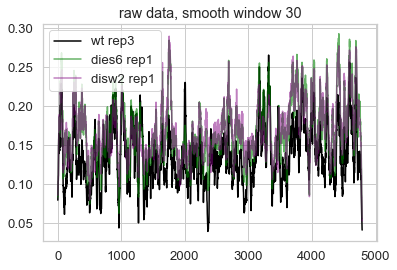

In [41]:
smooth_width = 30

sns.lineplot(x = range(4791), 
                 y = np.convolve(wt_rep3_plasmid_join.mean(axis=0), np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt rep3")
sns.lineplot(x = range(4791), 
                 y = np.convolve(dies6_rep1_plasmid_join.mean(axis=0), np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "green", label = "dies6 rep1", alpha=0.6)
sns.lineplot(x = range(4791), 
                 y = np.convolve(disw2_rep1_plasmid_join.mean(axis=0), np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "purple", alpha = 0.5, label = "disw2 rep1")
plt.title("raw data, smooth window " + str(smooth_width))

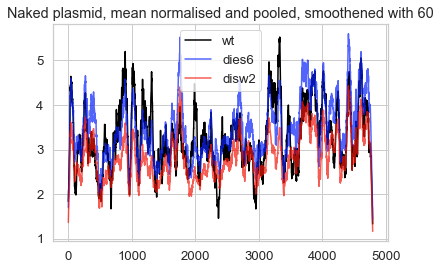

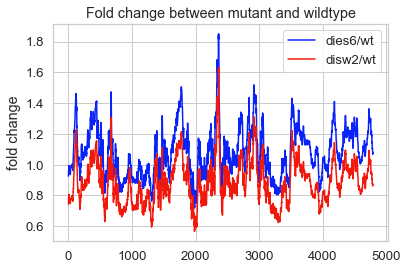

In [42]:
N=60

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Naked plasmid, mean normalised and pooled, smoothened with " + str(N)) #pooled and min-max normalised

plt.show()
#plt.savefig(load_dir + "/plots/average_smoothed_methylation_by_condition.png")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#0a22fa", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#f2180c",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

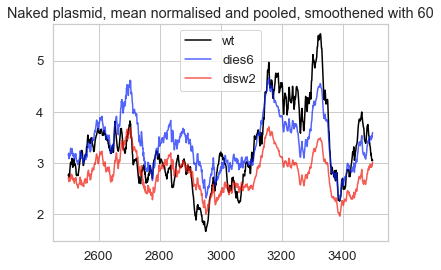

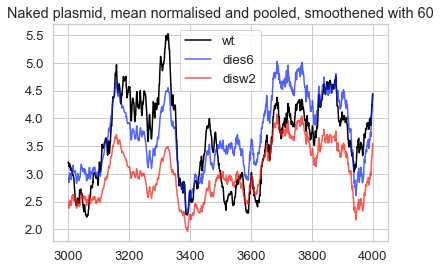

In [43]:
#show an inlet of the whole sequence:

sns.lineplot(x = range(2500, 3500),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same")[2500:3500],
             color = "black", 
            label = "wt")
sns.lineplot(x = range(2500, 3500),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")[2500:3500],
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(2500, 3500),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[2500:3500], 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Naked plasmid, mean normalised and pooled, smoothened with " + str(N))
plt.show()

sns.lineplot(x = range(3000, 4000),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same")[3000:4000],
             color = "black", 
            label = "wt")
sns.lineplot(x = range(3000,4000),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")[3000:4000],
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(3000,4000),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[3000:4000], 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Naked plasmid, mean normalised and pooled, smoothened with " + str(N))
plt.show()

## Plot the per base efficiency for the plasmid:

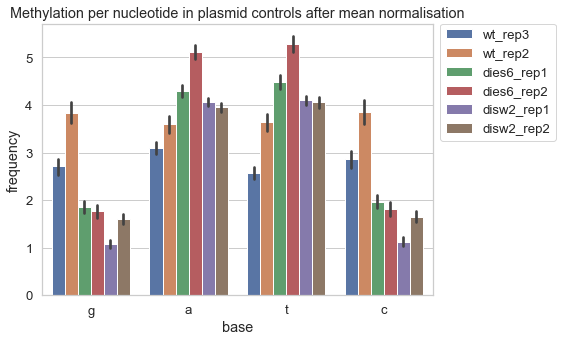

<AxesSubplot:title={'center':'Methylation frequency over samples'}, xlabel='sample', ylabel='normalized frequency of methylation'>

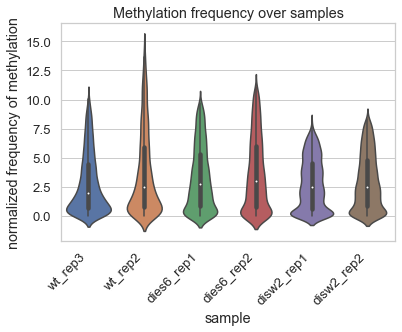

In [44]:
#prepare the data:
seq="ggaagatcctctagagtcgacccgagatcatatcactgtggacgttgatgaaagaatacgttattctttcatcaaatcgtggggctctagggtagttgcgtttctctcattgggacactgaacctcattttccaacattttggtcatgtaagaggcgacaggctcatcgcaggtgggtgcatcaacatggtagtacctggaccaagcgctacattgagtccctcctggataaacaccgctacaatattgtctttggacgtttgcccaaaccatatcttttgaataccaaagctggaccacattgtatggcctaatcattggtgctaccataatactggattgggaaacagtctggttaatttttttcaaccaatttttcttatctagcaatgatttaataaacctgaaatctaaattgtcttcgttagcgtctgtgtcataatctacaattgagtactgtgacgtccaattatatggcaccgagatggggaatctgtccggtgtttcgtcgctgttatccttctcctccctccaaatgaattcctgcagcccgggggatccactagttctagagcggccgccaccgcggtggagctccagcttttgttccctttagtgagggttaatttcgagcttggcgtaatcatggtcatagctgtttcctgtgtgaaattgttatccgctcacaattccacacaacatacgagccggaagcataaagtgtaaagcctggggtgcctaatgagtgagctaactcacattaattgcgttgcgctcactgcccgctttccagtcgggaaacctgtcgtgccagctgcattaatgaatcggccaacgcgcggggagaggcggtttgcgtattgggcgctcttccgcttcctcgctcactgactcgctgcgctcggtcgttcggctgcggcgagcggtatcagctcactcaaaggcggtaatacggttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctccgcccccctgacgagcatcacaaaaatcgacgctcaagtcagaggtggcgaaacccgacaggactataaagataccaggcgtttccccctggaagctccctcgtgcgctctcctgttccgaccctgccgcttaccggatacctgtccgcctttctcccttcgggaagcgtggcgctttctcatagctcacgctgtaggtatctcagttcggtgtaggtcgttcgctccaagctgggctgtgtgcacgaaccccccgttcagcccgaccgctgcgccttatccggtaactatcgtcttgagtccaacccggtaagacacgacttatcgccactggcagcagccactggtaacaggattagcagagcgaggtatgtaggcggtgctacagagttcttgaagtggtggcctaactacggctacactagaaggacagtatttggtatctgcgctctgctgaagccagttaccttcggaaaaagagttggtagctcttgatccggcaaacaaaccaccgctggtagcggtggtttttttgtttgcaagcagcagattacgcgcagaaaaaaaggatctcaagaagatcctttgatcttttctacggggtctgacgctcagtggaacgaaaactcacgttaagggattttggtcatgagattatcaaaaaggatcttcacctagatccttttaaattaaaaatgaagttttaaatcaatctaaagtatatatgagtaaacttggtctgacagttaccaatgcttaatcagtgaggcacctatctcagcgatctgtctatttcgttcatccatagttgcctgactccccgtcgtgtagataactacgatacgggagggcttaccatctggccccagtgctgcaatgataccgcgagacccacgctcaccggctccagatttatcagcaataaaccagccagccggaagggccgagcgcagaagtggtcctgcaactttatccgcctccatccagtctattaattgttgccgggaagctagagtaagtagttcgccagttaatagtttgcgcaacgttgttgccattgctacaggcatcgtggtgtcacgctcgtcgtttggtatggcttcattcagctccggttcccaacgatcaaggcgagttacatgatcccccatgttgtgcaaaaaagcggttagctccttcggtcctccgatcgttgtcagaagtaagttggccgcagtgttatcactcatggttatggcagcactgcataattctcttactgtcatgccatccgtaagatgcttttctgtgactggtgagtactcaaccaagtcattctgagaatagtgtatgcggcgaccgagttgctcttgcccggcgtcaatacgggataataccgcgccacatagcagaactttaaaagtgctcatcattggaaaacgttcttcggggcgaaaactctcaaggatcttaccgctgttgagatccagttcgatgtaacccactcgtgcacccaactgatcttcagcatcttttactttcaccagcgtttctgggtgagcaaaaacaggaaggcaaaatgccgcaaaaaagggaataagggcgacacggaaatgttgaatactcatactcttcctttttcaatattattgaagcatttatcagggttattgtctcatgagcggatacatatttgaatgtatttagaaaaataaacaaataggggttccgcgcacatttccccgaaaagtgccacctaaattgtaagcgttaatattttgttaaaattcgcgttaaatttttgttaaatcagctcattttttaaccaataggccgaaatcggcaaaatcccttataaatcaaaagaatagaccgagatagggttgagtgttgttccagtttggaacaagagtccactattaaagaacgtggactccaacgtcaaagggcgaaaaaccgtctatcagggcgatggcccactacgtgaaccatcaccctaatcaagttttttggggtcgaggtgccgtaaagcactaaatcggaaccctaaagggagcccccgatttagagcttgacggggaaagccggcgaacgtggcgagaaaggaagggaagaaagcgaaaggagcgggcgctagggcgctggcaagtgtagcggtcacgctgcgcgtaaccaccacacccgccgcgcttaatgcgccgctacagggcgcgtcccattcgccattcaggctgcgcaactgttgggaagggcgatcggtgcgggcctcttcgctattacgccagctggcgaaagggggatgtgctgcaaggcgattaagttgggtaacgccagggttttcccagtcacgacgttgtaaaacgacggccagtgaattgtaatacgactcactatagggcgaattgggtaccgggccccccctcgaggtcgacggtatcgataagcttttttgggtcctttgttttcgttgtttcagtctggataaattttaagttaccattatcgaaggcacttttgtacttgtcactaattaaagatgcaatgtcagcggggatactcatttttattttaatttttacttttctgtttgttctaaaatctatctaaactggctttcaagatcaatctattgtcttttaaggtaaactttaaattggaaataatagtaatgttagttccttcattttaaccttgtattgtatttcctttgcgtgatgaaaaaaaaactgaaaaagagaaaaataagaaaatcttctagaacgttccgaaacaggacacttagcacacaaatacagaataggaaagtaaaaggcaatatatgaatgcagtgcttgtaactggtgcttgtatccaagaatagcttcttgctgtaggttatgggaatatcgtgtaagctggggtgacttttgagctattcgcgacgcccgacgccgtaataactactttctcgacccgagatcatatcactgtggacgttgatgaaagaatacgttattctttcatcaaatcgtggtcgaccggcatgcaagctccctcgaggacagaccacttatgacagtatttcaggccgctcttataaaatgacatgttaacaaacagttctgattattcgccttttgacaggacgataatgtaaatagttgtggtagtatcattcaggtatgtaactgtttactttgtatcgcttgaaaaaaataagcatttcagagccttctttggagctcaagtggattgaggccacagcaagaccggccagtttgaatgctcaactcttcaaaagaaattcctcaaatatgtccagtttcatgtactgtccggtgtgatttattattttttatttactttgtagttcttaaagctaagatttttttctttgataaattcttgttttcatatcctaaaattaaagggaaaataaacaatacataacaaaacatataaaaaccaacacaataaaaaaaaggatcaaatactcattaaagtaacttacacgggggctaaaaacggagtttgatgaatattcacaagataaaaatcatatgtatgtttctgatatatcgatatacaatcaaacactttcaagaatttgtttgtagactttttgctagagacctcatcaaagtgctaccaactaagatcaacttatacttcttttagagaaaatttttttcaatgtactccaaagagatttagatcctgtctcttcctcttcctcttcctcgaaagtcaaagaaaaatcagagtctccc"
seq = seq.lower()

eff_df = pd.DataFrame({"wt_rep3": wt_rep3_minmax}, index=range(4791)) 

eff_df["base"] = [letter for letter in seq]

eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax


eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide in plasmid controls after mean normalisation")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("normalized frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Methylation frequency over samples")

g

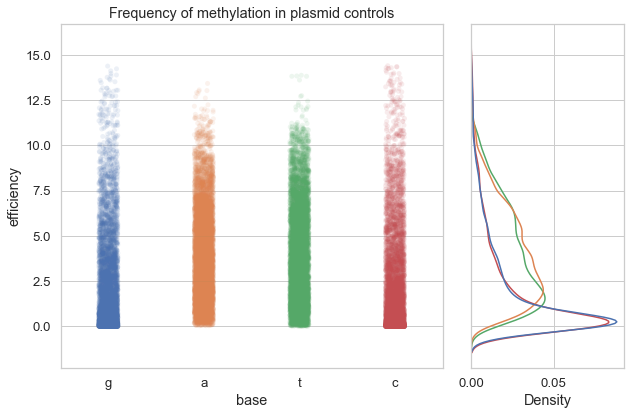

In [45]:
# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation in plasmid controls")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid.tif", dpi=300)

In [51]:
#Exporting aggregated data for Anna to plot for the manuscript 
#3rd June 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


plasmid_smooth_30 = pd.DataFrame.from_dict(smooth)
plasmid_smooth_30.index = plasmid_smooth_30.index + 1
#plasmid_smooth_30.to_csv("controls/plasmid_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same")
}

plasmid_FCs = pd.DataFrame.from_dict(FC)
plasmid_FCs.index = plasmid_FCs.index + 1

#plasmid_FCs.to_csv("controls/plasmid_smoothed_fold_changes_winsize_30.csv")

In [50]:
plasmid_smooth_30.describe()

,wt_pooled,wt_rep3,wt_rep2,dies6_rep1,dies6_rep2,dies6_pooled,disw2_rep1,disw2_rep2,disw2_pooled
count,4791.000000,4791.000000,4791.000000,4791.000000,4791.000000,4791.000000,4791.000000,4791.000000,4791.000000
mean,3.256708,2.805774,3.707642,3.264646,3.655338,3.459992,2.734132,2.930131,2.832131
std,0.909336,0.755176,1.069178,0.769090,0.878616,0.820644,0.568495,0.675323,0.614800
min,0.870240,0.807211,0.933270,1.084554,1.184867,1.134710,0.857835,0.986327,0.922081
25%,2.632865,2.287762,2.974328,2.725283,3.043277,2.892120,2.323781,2.470676,2.403188
50%,3.147521,2.715486,3.576075,3.158052,3.528038,3.340785,2.667194,2.838029,2.750045
75%,3.811358,3.278631,4.350776,3.721809,4.164821,3.943699,3.052575,3.329572,3.191710
max,6.637204,5.486733,7.787674,5.760980,6.557085,6.159033,4.712344,5.057983,4.854026


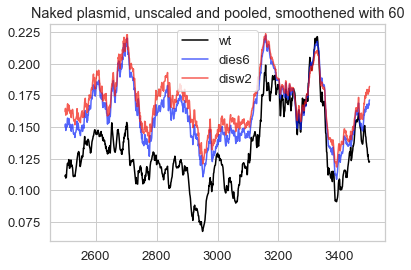

Text(0.5, 1.0, 'Naked plasmid, unscaled and pooled')

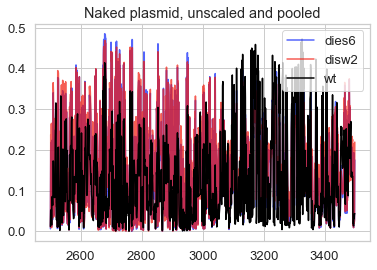

In [47]:
#Is the difference between wt and mutants an effect of the scaling?
N=60
#wt
pooled_wt = np.concatenate((wt_rep3_plasmid_join, wt_rep2_plasmid_join), axis = 0).mean(axis = 0)

#dies6
pooled_dies6 = np.concatenate((dies6_rep1_plasmid_join, dies6_rep2_plasmid_join), axis = 0).mean(axis = 0)

#disw2
pooled_disw2 = np.concatenate((disw2_rep1_plasmid_join, disw2_rep2_plasmid_join), axis = 0).mean(axis = 0)

sns.lineplot(x = range(2500, 3500),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same")[2500:3500],
             color = "black", 
            label = "wt")
sns.lineplot(x = range(2500, 3500),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")[2500:3500],
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(2500, 3500),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[2500:3500], 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title("Naked plasmid, unscaled and pooled, smoothened with " + str(N))
plt.show()

sns.lineplot(x = range(2500, 3500),
             y = pooled_dies6[2500:3500],
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(2500, 3500),
            y = pooled_disw2[2500:3500], 
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
sns.lineplot(x = range(2500, 3500),
             y = pooled_wt[2500:3500],
             color = "black", 
            label = "wt")
plt.title("Naked plasmid, unscaled and pooled")

<AxesSubplot:ylabel='Count'>

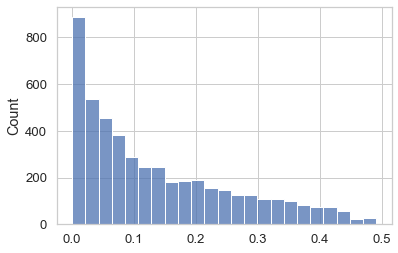

In [48]:
sns.histplot(wt_rep3_plasmid_join.mean(axis=0))